# Voltage Sag Exploration

## Summary
This notebook shows how to rapidly find voltage sag events by leveraging the tree structure of BTrDB. It accompanies [this NI4AI blog post](https://blog.ni4ai.org/post/2020-04-15-voltage-sags/). 

In [1]:
import btrdb
import numpy as np
import pandas as pd
import time

from btrdb.utils.timez import ns_delta, to_nanoseconds, ns_to_datetime
from btrdb.utils.general import pointwidth
from library.utils import get_global_mean_value, get_event_data, freq_vs_size, describe_streams

# Plotting
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
db = btrdb.connect(profile='ni4ai')
db.info()

{'majorVersion': 5, 'build': '5.12.5', 'proxy': {'proxyEndpoints': []}}

In [3]:
# Get voltage streams in the "sunshine" collection
streams = db.streams_in_collection('sunshine', tags={'unit':'volts'})
print(describe_streams(streams))

  Index  Collection     Name    Units    UUID
-------  -------------  ------  -------  ------------------------------------
      0  sunshine/PMU6  L2MAG   volts    d60fc469-a6da-4c98-8763-fd833293d955
      1  sunshine/PMU6  L3MAG   volts    4833b5e0-ef30-40ed-8db8-352e79d38c28
      2  sunshine/PMU2  L2MAG   volts    6ef43c96-9429-48db-9d37-bffd981b4a24
      3  sunshine/PMU6  L1MAG   volts    d3e9ed52-6db9-4b98-bfda-e1b509148e47
      4  sunshine/PMU2  L1MAG   volts    e290a69d-1e52-4411-bccd-da7c3f39531c
      5  sunshine/PMU2  L3MAG   volts    b4920286-9aaa-4ca0-82ac-937e3ff7d8e8
      6  sunshine/PMU3  L1MAG   volts    0295f80f-6776-4384-b563-4582f7256600
      7  sunshine/PMU3  L2MAG   volts    38d62795-6341-4069-96d3-fe74bffcac67
      8  sunshine/PMU3  L3MAG   volts    37539589-88aa-48b7-8cb4-1ea2f32c9e8d
      9  sunshine/PMU4  L1MAG   volts    08060a62-04c0-4597-8d2f-7df58e461ba2
     10  sunshine/PMU4  L3MAG   volts    5031918c-346f-4488-9755-b3917153e607
     11  sunshine/

## What are voltage sags?
A brief dip in voltage level is classified as a voltage sag when it exceeds 0.9 pu and lasts from 0.5 cycles to 0.5 seconds. Voltage sags smaller than this amount would generally go unnoticed or be neglected, but the power of BTrDB allows us to study even smaller dips. In the following, we find voltage sags across several days of measurements from the sunshine dataset. 

### Finding voltage sags
To find the voltage sags, we first write a depth-first-search function to find the timestamps below our voltage sag threshold. 

In [4]:
def find_sags_dfs(stream, tau, start=btrdb.MINIMUM_TIME, end=btrdb.MAXIMUM_TIME,
                   pw=48, version=0):
    """
    Finding all the sags(values below tau) using a depth first search algorithm in the specified stream.
    
    Parameters
    ----------
    stream : btrdb.Stream
        Stream object.
    tau : int or float
        Sag threshold. Points with values below this threshold will be marked as a sag.
    start : int or float, default=btrdb.MINIMUM_TIME
        Time to start finding sags.
    end : int or float, default=btrdb.MAXIMUM_TIME
        Time to stop finding sags.
    pw : int, default=48
        Pointwidth.  
    version : int, default=0
        Stream version.
        
    Yield
    ----------
    point : int
      Timestamp of the detected sag(points with values below the sag threshold). 
    """     
    # Ensure pw is a pointwidth object
    pw = pointwidth(pw)

    # Begin by collecting all stat points at the specified pointwidth
    # Note that zip creates a list of windows and versions and we ignore the versions
    statpoints, _ = zip(*stream.aligned_windows(start, end, pw, version))
    # Traversing from left to right from the windows
    for sp in statpoints:
        # Check to see if the value is in the window
        if sp.min <= tau:
            # Get the time range of the current window
            wstart = sp.time
            wend = sp.time + pw.nanoseconds

            if pw <= 30:
                # If we are at a window length of a second, use values
                points, _ = zip(*stream.values(wstart, wend, version))
            else:
                # Otherwise, traverse the stat point children of this node
                points = find_sags_dfs(stream, tau, wstart, wend, pw-1, version)

            # Yield all points to the calling function
            for point in points:
                if point.value <= tau:
                    yield point

In [6]:
start = "2015-10-31T00:00:00.000Z"
end = "2015-11-05T00:00:00.000Z"
# Sunshine PMU 13
stream = streams[13]
vnom = get_global_mean_value(stream)
thresh = 0.9 * vnom

sags = find_sags_dfs(stream, thresh, start=start, end=end)

Visualize a voltage sags from PMU 1 of the sunshine dataset. 

RawPoint(1446329045991666000, 5945.64599609375)


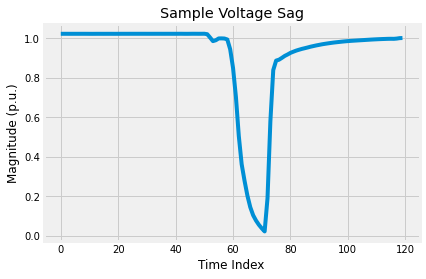

In [7]:
sag_point = next(sags)
print(sag_point)
sag_data = get_event_data(stream, sag_point[0])
plt.figure()
plt.plot(sag_data / vnom); plt.title('Sample Voltage Sag')
plt.xlabel('Time Index') 
plt.ylabel('Magnitude (p.u.)')
plt.show()

#plt.tight_layout();
#plt.savefig('example_sag', dpi=100);

Now that we have a function that finds voltage sags, we can write functions to analyze aspects of the sags, such as their size and duration. 

### Find voltage sags over one month of data
We look at voltage sags from November 20, 2016 to December 20, 2016. 

In [8]:
def sag_survey(sags, between_sags_in_sec=1, limit=100, verbose=False):
    """
    Consolidate individual sag points into distinct sags based on the time between them.
    
    Parameters
    ----------
    sags : Generator
        Timestamps of individual sag points (points with values below the sag threshold).
    between_sags_in_sec : int or float, default=1
        Time gap threshold. Adjacent sags less than this value apart are combined into a single sag.
    limit : int, default=100
        Limit on number of sags to return.
    verbose : bool, default=False
        Progress of sag survey.  
        
    Return
    ----------
    starts : list of int
        Starting timestamps of the unique sags found.
    durations : list of int
        Time duration of each sag in nanoseconds.
    magnitudes : list of int
        Minimum value found among the combined sags.
    sags_found : list of int
      Number of unique sags found. 
      
    Examples
    ----------
    >>> vsags = find_sags_dfs(voltage_stream, voltage_thresh, start=start, end=end)
    >>> vsags_start_time, vsags_duration, vsags_magnitude, vsags_found = sag_survey(vsags, between_sags_in_sec=1)
    """  
    # Initialize sag information
    starts = []
    durations = []
    magnitudes = [] 
    sags_found=[]
    
    # Get the first sag
    sag = safe_next(sags)
    if sag==None: 
        print("No voltage sags found.")
    else:
        if verbose: print("Voltage sag found!")
        start, mag = sag
        dur = 0
    
    count = 0 
    sags_count=1
    while sag:
        sag = safe_next(sags)
        # If we are on the last sag
        if (sag == None) or (count > limit):
            starts.append(start)
            durations.append(dur)
            magnitudes.append(mag)
            sags_found.append(sags_count)
            sag = None
        else:
            sag_time, sag_value = sag
            # Check if this is a different sag
            # More than 1s or more after last sag point
            if sag_time - (start + dur) > between_sags_in_sec*1e9:
                if verbose: print("Voltage sag found!", count)
                # Save last sag
                starts.append(start)
                durations.append(dur)
                magnitudes.append(mag)
                sags_found.append(sags_count)
                # Increment sag count
                count += 1
                # Initialize next sag
                start = sag_time 
                mag = sag_value
                dur = 0
                sags_count = 0
            # Otherwise update properties of this sag
            else:
                dur = sag_time - start 
                mag = min(mag, sag_value)
            sags_count += 1
                
    return starts, durations, magnitudes, sags_found

# A convenience for iterating through a generator
def safe_next(iterable):
    """
    Helper function for sag_survey() to ensure it does not run into StopIteration error when all values have been evaluated.
    """
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first

In [10]:
# Choose the stream
# PMU 1 from sunshine dataset
stream = streams[13]
# Get nominal voltage of stream
vnom = get_global_mean_value(stream)

# Start and end times of period to study
start = "2016-11-20T00:00:00.000Z"
end = "2016-12-20T00:00:00.000Z"

# Threshold below which data is considered a voltage sag
thresh = 0.98 * vnom 

# For timing - start
go = time.time()

# Find voltage sag data points
sags = find_sags_dfs(stream, thresh, start=start, end=end) 
# Get features of voltage sags
starts, durs, mags, sags_counts = sag_survey(sags, verbose=False)

# For timing - end
stop = time.time()

# Print magnitudes of sags
print(mags)
print('Time: ', stop-go)

[6769.9267578125, 6753.34423828125, 6851.3955078125, 6591.23486328125]
Time:  1.0938057899475098


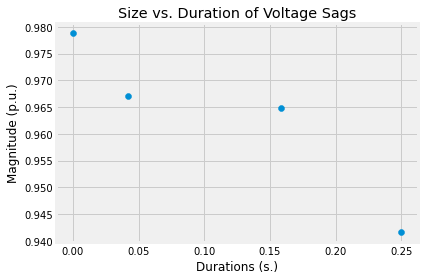

In [16]:
plt.scatter(np.array(durs) / 1e9, np.array(mags) / vnom)
plt.title('Size vs. Duration of Voltage Sags')
plt.xlabel('Durations (s.)')
plt.ylabel('Magnitude (p.u.)')

plt.tight_layout()
plt.show()
# plt.savefig('size_vs_durs', dpi=100)

### Find voltage sags over 3 months of data.
We look at voltage sags from November 19, 2016 to February 4, 2017. 

In [17]:
# Choose the stream
# PMU 1 from sunshine dataset
stream = streams[13]
# Get nominal voltage of stream
vnom = get_global_mean_value(stream)

# Start and end times of period to study
start = "2016-11-19T00:00:00.000Z"
end = "2017-02-04T00:00:00.000Z"

# Threshold below which data is considered a voltage sag
thresh = 0.99 * vnom

# Find voltage sag data points
sags = find_sags_dfs(stream, thresh, start=start, end=end) 
# Get features of voltage sags
starts, durs, mags, sags_counts = sag_survey(sags, verbose=False)

### Sag Features
Now we can explore patterns and features of the voltage sags found across several months of data. 

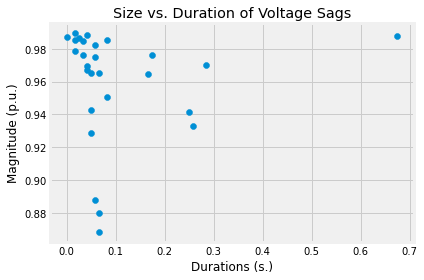

In [18]:
plt.scatter(np.array(durs) / 1e9, np.array(mags) / vnom)
plt.title('Size vs. Duration of Voltage Sags')
plt.xlabel('Durations (s.)')
plt.ylabel('Magnitude (p.u.)')

plt.tight_layout()
# plt.savefig('size_vs_durs', dpi=100)

Let's compare the empirical size & frequency of the voltage sags to a model proposed in the literature. 

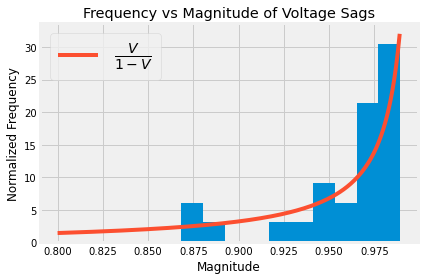

In [19]:
# Plot a histogram of the normalized magnitude
# of the voltage sags
pmags = mags / vnom
plt.hist(pmags, density=True)

# A result in the literature says that the frequency of
# a voltage sag with minimum value V will be V / (1-V)
# Plot this fit
x, y = freq_vs_size(0.8, 0.99)
plt.plot(x, y, label = r'$\frac{V}{1-V}$')

# Add keys
plt.legend(fontsize=20)
plt.title('Frequency vs Magnitude of Voltage Sags') 
plt.xlabel('Magnitude') 
plt.ylabel('Normalized Frequency')

plt.tight_layout()
# plt.savefig('freq_vs_voltage', dpi=100)

### Compare voltage sag occurrences at multiple locations. 

In [21]:
# Choose the stream
# PMU 1 from sunshine dataset (PV site)
stream1 = streams[13]#uuid : "35bdb8dc-bf18-4523-85ca-8ebe384bd9b5"
# PMU 3 from sunshine dataset (substation above PV site)
stream2 = streams[6]#uuid : "0295f80f-6776-4384-b563-4582f7256600"
# PMU 4 from sunshine dataset (substation)
stream3 = streams[9]#uuid : "08060a62-04c0-4597-8d2f-7df58e461ba2"
# PMU 5 from sunshine dataset (substation)
stream4 = streams[16]#uuid : "edb36769-f56f-47c5-bbda-a177c424cc4f"

# Get nominal voltage of stream
vnom1 = get_global_mean_value(stream1); 
vnom2 = get_global_mean_value(stream2);
vnom3 = get_global_mean_value(stream3);
vnom4 = get_global_mean_value(stream4);

# Start and end times of period to study
start = "2016-03-01T00:00:00.000Z"
end = "2016-06-01T00:00:00.000Z"

# Threshold below which data is considered a voltage sag
level = 0.97
thresh1 = level * vnom1; 
thresh2 = level * vnom2; 
thresh3 = level * vnom3; 
thresh4 = level * vnom4;

# Find voltage sag data points
sags1 = find_sags_dfs(stream1, thresh1, start=start, end=end);
sags2 = find_sags_dfs(stream2, thresh2, start=start, end=end); 
sags3 = find_sags_dfs(stream3, thresh3, start=start, end=end);
sags4 = find_sags_dfs(stream4, thresh4, start=start, end=end);

# Get features of voltage sags
print("Searching in stream 1...")
starts1, durations1, magnitudes1, sags_counts1 = sag_survey(sags1, verbose=False);
print("Searching in stream 2...")
starts2, durations2, magnitudes2, sags_counts2 = sag_survey(sags2, verbose=False);
print("Searching in stream 3...")
starts3, durations3, magnitudes3, sags_counts3 = sag_survey(sags3, verbose=False);
print("Searching in stream 4...")
starts4, durations4, magnitudes4, sags_counts4 = sag_survey(sags4, verbose=False);

Searching in stream 1...
Searching in stream 2...
Searching in stream 3...
Searching in stream 4...


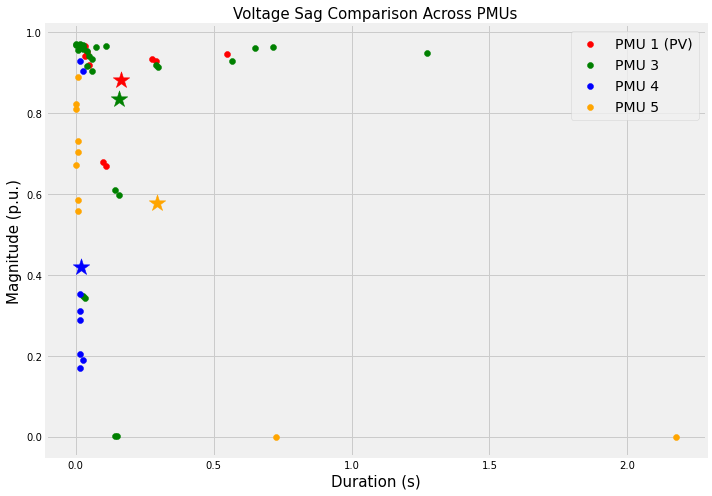

In [23]:
plt.figure(figsize=(10, 7))
plt.scatter(np.array(durations1) / 1e9, np.array(magnitudes1) / vnom1, c='r', label='PMU 1 (PV)');
plt.scatter(np.array(durations2) / 1e9, np.array(magnitudes2) / vnom2, c='g', label='PMU 3');
plt.scatter(np.array(durations3) / 1e9, np.array(magnitudes3) / vnom3, c='b', label='PMU 4');
plt.scatter(np.array(durations4) / 1e9, np.array(magnitudes4) / vnom4, c='orange', label='PMU 5');
plt.legend(fontsize=14); 

# Plot average durations and magnitude for each PMU
plt.scatter(np.mean(np.array(durations1) / 1e9), np.mean(np.array(magnitudes1) / vnom1), c='r', s=300, marker='*');
plt.scatter(np.mean(np.array(durations2) / 1e9), np.mean(np.array(magnitudes2) / vnom2), c='g', s=300, marker='*');
plt.scatter(np.mean(np.array(durations3) / 1e9), np.mean(np.array(magnitudes3) / vnom3), c='b', s=300, marker='*');
plt.scatter(np.mean(np.array(durations4) / 1e9), np.mean(np.array(magnitudes4) / vnom4), c='orange', s=300, marker='*');

plt.xlabel("Duration (s)", fontsize=15); 
plt.ylabel("Magnitude (p.u.)", fontsize=15);
plt.title("Voltage Sag Comparison Across PMUs", fontsize=15);

plt.tight_layout();
plt.savefig('sag_comparison', dpi=100);

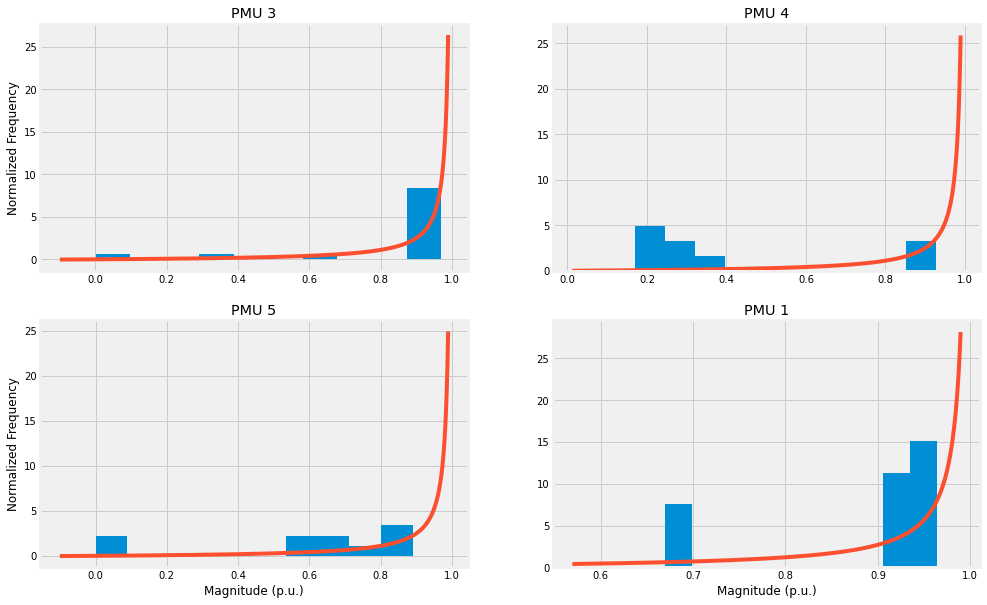

In [24]:
# Histogram comparing size of sags. 
fig = plt.figure(figsize=(15, 10)); 

plt.subplot(2, 2, 1)
plt.hist(np.array(magnitudes2) / vnom2, density=True);
min_mag = np.min(np.array(magnitudes2) / vnom ) - 0.1; 
x, y = freq_vs_size(min_mag, 0.99);
plt.plot(x, y)
plt.title('PMU 3')
plt.ylabel('Normalized Frequency')

plt.subplot(2, 2, 2)
plt.hist(np.array(magnitudes3) / vnom3, density=True);
min_mag = np.min(np.array(magnitudes3) / vnom ) - 0.1; 
x, y = freq_vs_size(min_mag, 0.99);
plt.plot(x, y)
plt.title('PMU 4')

plt.subplot(2, 2, 3)
plt.hist(np.array(magnitudes4) / vnom4, density=True);
min_mag = np.min(np.array(magnitudes4) / vnom ) - 0.1; 
x, y = freq_vs_size(min_mag, 0.99);
plt.plot(x, y)
plt.title('PMU 5')
plt.xlabel('Magnitude (p.u.)')
plt.ylabel('Normalized Frequency')

plt.subplot(2, 2, 4)
plt.hist(np.array(magnitudes1) / vnom1, density=True);
min_mag = np.min(np.array(magnitudes1) / vnom ) - 0.1; 
x, y = freq_vs_size(min_mag, 0.99);
plt.plot(x, y)
plt.title('PMU 1')
plt.xlabel('Magnitude (p.u.)');

### Weekly patterns in voltage sags. 

In [25]:
# PMU 4 from sunshine dataset (substation)
stream1 = streams[9] #uuid : "08060a62-04c0-4597-8d2f-7df58e461ba2"
# PMU 5 from sunshine dataset (substation)
stream2 = streams[16] # uuid : "edb36769-f56f-47c5-bbda-a177c424cc4f"

# Get nominal voltage of stream
vnom1 = get_global_mean_value(stream1)
vnom2 = get_global_mean_value(stream2)

# Start and end times of period to study
start = "2016-03-01T00:00:00.000Z"
end = "2016-06-01T00:00:00.000Z"

# Threshold below which data is considered a voltage sag
level = 0.98
thresh1 = level * vnom1
thresh2 = level * vnom2

# Find voltage sag data points
sags1 = find_sags_dfs(stream1, thresh1, start=start, end=end)
sags2 = find_sags_dfs(stream2, thresh2, start=start, end=end)

# Get features of voltage sags
print("Searching in stream 1...")
starts1, durations1, magnitudes1, sags_counts1 = sag_survey(sags1, verbose=False)
print("Searching in stream 2...")
starts2, durations2, magnitudes2, sags_counts2 = sag_survey(sags2, verbose=False)

Searching in stream 1...
Searching in stream 2...


In [26]:
def get_day_counts(times):
    counts = np.zeros(7)
    
    N = np.size(times)
    days = np.zeros(N)
    
    i = 0
    for time in times:
        dt = ns_to_datetime(time)
        day = int(dt.weekday())
        counts[day] += 1
        days[i] = day 
        i+=1
        
    return counts, days;

counts1, D1 = get_day_counts(starts1);
counts2, D2 = get_day_counts(starts2);

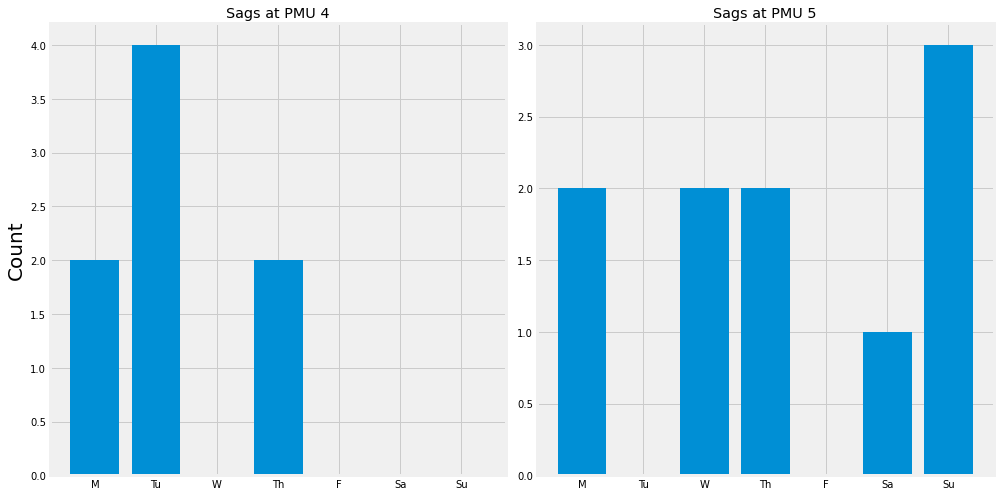

In [27]:
daysofweek = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']

plt.figure(figsize=(14, 7)) 
plt.subplot(1, 2, 1)
plt.bar(daysofweek, counts1, align='center')
plt.title('Sags at PMU 4')
plt.ylabel('Count', fontsize=20)

plt.subplot(1, 2, 2)
plt.bar(daysofweek, counts2, align='center')
plt.title('Sags at PMU 5');

plt.tight_layout()
# plt.savefig('sags_by_day', dpi=100)